# Image segmentation using Quantum k-means algorithm

In this notebook, we perform image segmentation by clustering pixels into two or more groups to identify objects within the image, such as determining weather a building is present. This notebook begins with a classical implementation of the k-means algorithm for image segmentation. Then, a quantum k-means algorithm for image segmentation is implemented.

This notebook is an example how quantum k-means as well as the classical k-means algorithm can be used for image segmentation. Image segmentation can be used to recognize different objects or areas of a picture. Image segmentation can help to recognize patterns or elements from the image so that the images can be clustered into different categhories or studied more. For example, in this notebook, satellite images in RGB from the EuroSAT data set are segmented [[1]](#references). The segmentation allows fro easier recognition of different types of fields, buildings, or water areas. The segmenatation of these images is done based on the intensity of the pixels. The quantum algorithm is the same as the one used in the "QKmeans" notebook, where more detailed explanations and justifications for the steps of the quantum circuit can be found, along with the basics of the classical K-means algorithm.

The steps in this notebook are the following:
1. Importing the necessary libraries

2. Using the classical k-means for image segmentation

3. Creating and using the quantum k-means algortihm for image segmentation

## Importing the necessary libraries

The libraries used in the notebook are imported here.

In [1]:
# The libraries for the classical part of the algorithm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.cluster import KMeans

# The libraries for the quantum part of the algorithm
from qiskit import Aer, IBMQ, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from iqm.qiskit_iqm import IQMProvider, IQMFakeAdonis
from iqm.qiskit_iqm import optimize_single_qubit_gates
from qiskit.circuit.library import StatePreparation

## The classical k-means

The classical k-means is used for this part of the notebook. First, the image can be read and shown to see what is the original picture that is being clustered. Then the image is reshaped. The picture is originally 64 pixels wide and high and it has three color channels red, gren and blue (it is an RGB image). The reshaping gives a two dimensional array with all of the pixels and the corresponding color values. After the reshaping, the k-means from Scikit-learn can be used to cluster the image. Finally the clustered image is plotted.

(64, 64, 3)


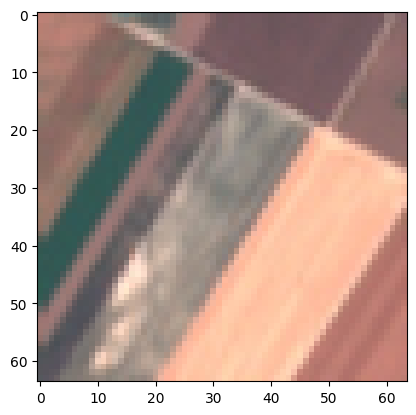

In [2]:
# Choosing the image. To cluster another image change the path to that image
pic = plt.imread('AnnualCrop_1623.jpg')/255
print(pic.shape)
plt.imshow(pic)

In [3]:
# Reshaping the image to 2D
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(4096, 3)

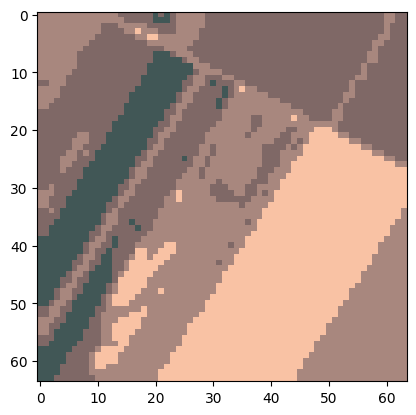

In [4]:
# Classical k-means algorithm and plotting the clustered image
kmeans = KMeans(n_clusters=4, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

## The quantum k-means

In this section the quantum k-means is created and run. The quantum algorithm starts with initializing the backend options. Then the picture is transformed from RGB to grayscale and flattened into a one dimesional array. The array has now each pixels color value in grayscale. The values of the pixels need to be encoded into the qubits. To do so an amplitude encoding function is created. The amplitude function is used in the distance computation function that uses a quantum circuit with a swap test to calculate the distance. The details for each function can be found in the "QKmeans" notebook. 

The only difference is that in this quantum k-means implementation the difference of the quantum states in not determined by the Euclidian distance but the probability of the ancilla qubit being in state $1$. The probability is an estimator of the fidelity which describes the similarity of two quantum states. If the ancilla is in the state $0$ the pixel values are identical and if not the probability represents the similarity so distance between them. 

Then the classical functions of the quantum k-means are done. This includes setting initial centroids, calculating the nearest centroid, and updating the centroids. After that the quantum k-means can be run. It takes distance between the pixels and the centroids are calculated and the centroids are updated, this is done for a few rounds do that the centroids can converge into the best possible ones. Finally, the clustered picture is plotted.

In [5]:
## CHOOSE BACKEND HERE
#backend_id = 'Helmi'
#backend_id = 'FakeAdonis'    # Fake Helmi simulator
backend_id = 'statevector_simulator'

# Helmi
# Note that this is a real quantum computer and requires access to it and it limits the amount of qubits to 5
if (backend_id == 'Helmi'):
    HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
    provider = IQMProvider(HELMI_CORTEX_URL)
    backend = provider.get_backend()

# Noisy simulator of Helmi 
# This is a simulator that has a noise profile similar to Helmi and it limits the amount of qubits to 5
if (backend_id == 'FakeAdonis'):
    backend = IQMFakeAdonis()

# Ideal simulator
if (backend_id == 'statevector_simulator'):
    backend = Aer.get_backend('statevector_simulator')

print(backend.operation_names)

['measure', 'mcrx', 'initialize', 'cu3', 'mcu1', 'rzz', 'multiplexer', 'cy', 'u1', 'kraus', 'r', 'sxdg', 'sdg', 'save_probs', 'mcrz', 'swap', 'cz', 'roerror', 'mcry', 'csx', 'h', 'p', 'cx', 'u3', 'rzx', 'mcu', 'save_statevector', 'ryy', 'u2', 'sx', 'reset', 's', 'mcswap', 'mcp', 'y', 'save_amplitudes_sq', 'diagonal', 'mcz', 'quantum_channel', 'set_statevector', 'unitary', 'rxx', 'pauli', 'save_amplitudes', 'tdg', 'z', 'ry', 'save_state', 'cswap', 't', 'cp', 'mcx', 'mcy', 'x', 'save_density_matrix', 'delay', 'ccx', 'cu1', 'id', 'mcr', 'mcsx', 'u', 'save_probs_ket', 'mcu2', 'cu2', 'save_expval', 'cu', 'mcu3', 'rz', 'qerror_loc', 'rx', 'mcphase']


In [6]:
# Changing to gray scale
if len(pic.shape) == 3:
    pic = np.mean(pic, axis=2)

# Flatten the image to a 1D array of pixel values
pixels = pic.flatten()
pixels = pixels.reshape(-1, 1)
print(len(pixels))

4096


In [7]:
# Amplitude encoding of the data

def get_phi_psi(A, B):
    sum_A = sum(a**2 for a in A)
    sum_B = sum(b**2 for b in B)

    A_norm = math.sqrt(sum_A)
    B_norm = math.sqrt(sum_B)
    Z = A_norm**2 + B_norm**2

    # creating phi and psi states
    phi = [A_norm/math.sqrt(Z), B_norm/math.sqrt(Z)]
    psi = []
    for i in range(len(A)):
        psi.append(((A[i] / A_norm) / math.sqrt(2)))
        psi.append(((B[i] / B_norm )/ math.sqrt(2)))

    next_power_of_2 = 2 ** math.ceil(math.log2(len(psi)))
    while len(psi) < next_power_of_2:
        psi.append(0)
    
    return phi, psi, Z

In [8]:
# Two different fucntions for getting the Euclidean distance, if the code is run on Helmi for data that has one or two features use get_Distance
# and if you want to run it for more complicated data that requires more qubits use get_Distance_general

def get_Distance(x,y):
    # Using the amplitude encoding function to store the features in the states
    phi, psi, Z = get_phi_psi(x,y)
    phi = np.array(phi) / np.linalg.norm(phi)
    psi = np.array(psi) / np.linalg.norm(psi)

    # Preparations for the quantum circuit
    num_qubits = 5
    # Third qubit is ancilla (see Helmi layout)
    ancilla_index = 2

    qr = QuantumRegister(num_qubits, name='qr')
    cr = ClassicalRegister(1, name='cr')
    qc = QuantumCircuit(qr, cr, name='k_means')

    # Intitializing the quantum states with the state vectors
    # Append is used as Helmi does not have "reset" in its native gates and the Qiskit function "initialize" uses it
    qc.append(StatePreparation(phi, normalize=False), [0])
    qc.append(StatePreparation(psi, normalize=False), [1])

    # Initializing the ancilla qubit
    qc.h(ancilla_index)
    # The swap test to compute the similarity between the two points/vectors
    qc.cswap(ancilla_index, 0, 1)
    # Superposition away from ancilla
    qc.h(ancilla_index)
    # Measure ancilla
    qc.measure(ancilla_index, 0)

    # Running the circuit and getting the results
    transpiled = transpile(qc, backend, optimization_level=3, seed_transpiler=1)
    #optimized = optimize_single_qubit_gates(transpiled, backend)   # use this if you are running the code on Helmi or the noisy simulator of Helmi
    shots = 1024.0
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    data = result.get_counts()

    # Computing the similarity 
    if '1' not in data:
        return 0.0     # the ancilla was never measured as 1 and the feature vectors are close to each other or identical
    else:
        return data['1']/1024.0  
                   
def get_Distance_general(x, y):
    # Using the amplitude encoding function to store the features in the states
    phi, psi, Z = get_phi_psi(x,y)
    phi = np.array(phi) / np.linalg.norm(phi)
    psi = np.array(psi) / np.linalg.norm(psi)

    # Preparations for the quantum circuit
    num_psi = int(np.ceil(np.log2(len(psi))))
    num_qubits = num_psi +2                    # we need one more qubit to be the ancilla and psi 

    qr = QuantumRegister(num_qubits, name='qr')
    cr = ClassicalRegister(1, name='cr')
    qc = QuantumCircuit(qr, cr, name='k_means')

    # Intitializing the quantum states with the encoded features
    qc.initialize(phi,1)
    qc.initialize(psi, list(range(2, num_psi+2)))
    # Initializing the ancilla qubit
    qc.h(0)
    # The SWAP test to compute the distance between the two points/vectors
    qc.cswap(0,1,2)
    # Superposition away from ancilla
    qc.h(0)
    # Measure ancilla
    qc.measure(0, 0)
    # Running the circuit and getting the results
    transpiled = transpile(qc, backend, seed_transpiler=1)
    shots = 1024
    job = backend.run(transpiled, shots=shots)
    result = job.result()
    data = result.get_counts()

    # Computing the similarity
    if '1' not in data:
        return 0.0      # the ancilla was never measured as 1 and the feature vectors are close to each other or identical
    else:
        return data['1']/1024.0

In [9]:
# Initializing the centers
# This is the first random guess where the centers could be
def initial_centers(points,k):
    return points[np.random.randint(points.shape[0], size=k), :]


In [10]:
# A function to find the closest cluster to a pixel. It takes as parameters the points which is the data that is going to be clusteres and the current centroids. 
# Then for each point the distance to each cluster is calculated. When the smallest distance is found that label is saved in the array pred_labels

def find_nearest_cluster(points, centroids):
    n = len(points)
    k = centroids.shape[0]
    pred_labels = np.zeros(n, dtype=int)

    for i in range(n):
        minimum_distance = float('inf')
        cluster_label = -1
        for j in range(k):
            p = points[i]
            c = centroids[j]
            temp_dis = get_Distance(p,c)
            if temp_dis < minimum_distance:
                minimum_distance = temp_dis
                cluster_label = j
        if cluster_label == -1:
            raise ValueError(f"No valid centroid found for point {i}")
        pred_labels[i] = cluster_label

    return pred_labels

In [11]:
# A function for updating the centroids based on the mean of the vectors belonging into that cluster

def get_centroids(points, pred_labels):
    k = int(np.max(pred_labels))+1
    centroids = np.zeros((k, points.shape[1]))

    for i in range(k):
        if np.sum(pred_labels == i) == 0:
            centroids[i, :] = points[np.random.randint(points.shape[0])]
        else :
            centroids[i, :] = np.mean(points[pred_labels == i], axis=0)

    return centroids

/Users/mmakital/opt/miniconda3/envs/projectenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mmakital/opt/miniconda3/envs/projectenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0
Iteration 0:
Centroids:
[[0.7684541 ]
 [0.43030052]
 [0.49968836]
 [0.710903  ]]
Unique labels: [0 1 2 3]
1
Iteration 1:
Centroids:
[[0.79075367]
 [0.39271938]
 [0.528522  ]
 [0.66354372]]
Unique labels: [0 1 2 3]
2
Iteration 2:
Centroids:
[[0.79871526]
 [0.38271259]
 [0.52254523]
 [0.64022331]]
Unique labels: [0 1 2 3]
3
Iteration 3:
Centroids:
[[0.79823346]
 [0.37641517]
 [0.51553277]
 [0.63040045]]
Unique labels: [0 1 2 3]
4
Iteration 4:
Centroids:
[[0.79635322]
 [0.37201898]
 [0.50895455]
 [0.61824509]]
Unique labels: [0 1 2 3]
5
Iteration 5:
Centroids:
[[0.79562992]
 [0.36832393]
 [0.50312602]
 [0.60885578]]
Unique labels: [0 1 2 3]
6
Iteration 6:
Centroids:
[[0.79409563]
 [0.36599308]
 [0.49958696]
 [0.60208784]]
Unique labels: [0 1 2 3]
7
Iteration 7:
Centroids:
[[0.79447977]
 [0.36437238]
 [0.49588515]
 [0.5981449 ]]
Unique labels: [0 1 2 3]
8
Iteration 8:
Centroids:
[[0.79407868]
 [0.36331805]
 [0.49337678]
 [0.59471297]]
Unique labels: [0 1 2 3]
9
Iteration 9:
Centroids:
[[

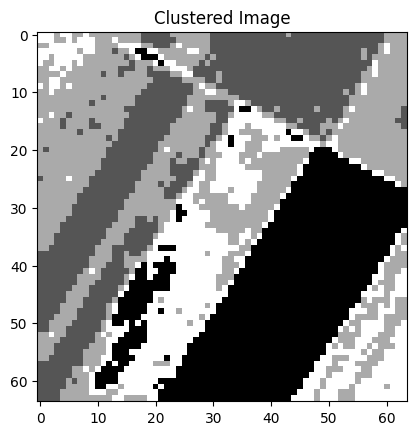

In [12]:
# Choosing the number of centers
k=4
# Initial guess for the centroids
centroids = initial_centers(pixels, k)

# Running the quantum k-means algorithm
# Finding the cluster for each vector based on the distance and the updating the centroids
# This part can be run as many times as necessary. The number of iterations can silghtly affect the results
for i in range(15):
    pred_labels = find_nearest_cluster(pixels, centroids)
    centroids = get_centroids(pixels, pred_labels)
    print(i) # This helps the tracking of the algorithm, how many rounds are still left and if all of the centroids still exist
    print(f"Iteration {i}:")
    print(f"Centroids:\n{centroids}")
    print(f"Unique labels: {np.unique(pred_labels)}")
cluster_labels = pred_labels

# Reshape cluster labels to match the original image shape
clustered_image = cluster_labels.reshape(pic.shape) / (k-1)

# Visualize the clustered image
plt.imshow(clustered_image, cmap='gray')
plt.title('Clustered Image')
plt.show()

## References:

[1] [P. Helber, B. Bischke, A. Dengel, and D. Borth, EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification, Jul. 2018.](https://zenodo.org/records/7711810)

## Acknowledgement

- The classical functions for the quantum k-means algorithm are modified based on the code available in [this GitHub](https://github.com/smit14/Quantum-K-means-algorithm/blob/master/k_means_quantum.ipynb)
- The amplitude encoding function is modified from the code presented in [this blog post by Qiskit](https://medium.com/qiskit/calculate-quantum-euclidean-distance-with-qiskit-df85525ab485)
- Thank you for their important contribution!